In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt

from phase_retrieval import PhaseRetSolver
from image_generator import gen_image

In [2]:
import matplotlib as mpl
import matplotlib.image as mpimg

# disable axes drawing, since we are showing images
mpl.rc("axes.spines", top=False, bottom=False, left=False, right=False)
mpl.rc("axes", facecolor="white")
mpl.rc("xtick", bottom=False, labelbottom=False)
mpl.rc("ytick", left=False, labelleft=False)

# center images
from IPython.core.display import HTML

HTML(
    """
<style>
.jp-RenderedImage, .output_png{
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
"""
)

In [3]:
def proj_A(f0, exp_data):
    f1 = np.fft.fftn(f0)
    f1 = exp_data * np.exp(1j * np.angle(f1))
    f1 = np.fft.ifftn(f1).real

    return f1


def proj_supp(f0, support_mask):
    f2 = f0 * support_mask
    return f2

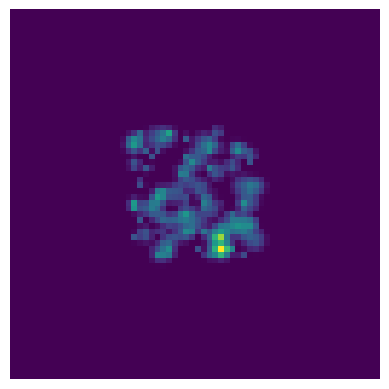

In [4]:
real_image, support = gen_image(
    n_pixels=32, n_pad=2, k=2, n_disks=100, seed=0, supp_neigh=1
)
exper_data = np.abs(np.fft.fftn(real_image))

plt.imshow(real_image)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

f1, s1 = gen_image(n_pixels=128, n_pad=2, k=0, n_disks=100, seed=0, supp_neigh=0)
f2, _ = gen_image(n_pixels=128, n_pad=2, k=2, n_disks=100, seed=0, supp_neigh=1)
f3, _ = gen_image(n_pixels=128, n_pad=2, k=4, n_disks=100, seed=0, supp_neigh=3)

_, s2 = gen_image(n_pixels=128, n_pad=2, k=0, n_disks=100, seed=0, supp_neigh=1)
_, s3 = gen_image(n_pixels=128, n_pad=2, k=0, n_disks=100, seed=0, supp_neigh=3)

ax[0, 0].imshow(f1)
ax[0, 1].imshow(f2)
ax[0, 2].imshow(f3)

ax[1, 0].imshow(s1)
ax[1, 1].imshow(s2)
ax[1, 2].imshow(s3)

ax[0, 1].set_title("(a) Images for k = 0, 2, 4", fontsize=17)
ax[1, 1].set_title("(b) p-support neighborhoods for p = 0, 1, 3", fontsize=17)

plt.savefig("images_and_supp.pdf", bbox_inches="tight")

In [5]:
phase_ret_sol = PhaseRetSolver()

In [36]:
config = {"n_iter": 20000, "restart_steps": np.arange(50, 100 + 50, 50), "n_recons": 1}

proj_A_args = (exper_data,)
proj_supp_args = (support,)

In [37]:
phase_ret_sol.set_proj_B(proj_supp, args=proj_supp_args)
phase_ret_sol.set_proj_A(proj_A, proj_A_args)
phase_ret_sol.set_config_from_dict(config)

In [42]:
exper_data

init_image = np.fft.ifftn(
    exper_data * np.exp(2j * np.pi * np.random.rand(*exper_data.shape))
).real
_, final_image, res = phase_ret_sol.run_diffmap_algo(init_image)

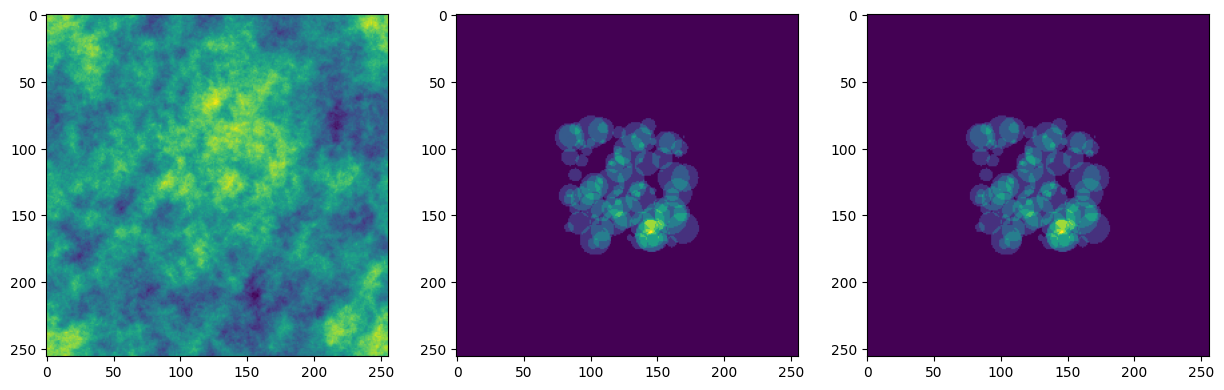

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(init_image)
ax[1].imshow(final_image, vmin=0, vmax=1)
ax[2].imshow(real_image, vmin=0, vmax=1)

In [ ]:
def solve(self, ref_data):
    real_img_famp = np.abs(np.fft.fftn(ref_data))
    final_images = np.zeros((self.config_["n_recons"], *ref_data.shape))
    recon_images = np.zeros((self.config_["n_recons"], *ref_data.shape))
    errors = np.zeros(self.config_["n_recons"])
    residuals = np.zeros((self.config_["n_recons"], self.config_["n_iter"]))

    for i in range(self.config_["n_recons"]):
        init_image_hat = real_img_famp * np.exp(
            2 * np.pi * 1j * np.random.rand(*real_img_famp.shape)
        )
        init_image = np.fft.ifftn(init_image_hat)

        final_image, recon, res = self.run_diffmap_algo(init_image)
        # recon = register_to_reference(recon, ref_data)
        errors[i] = compute_residual(recon, ref_data)
        residuals[i] = res.flatten()

        recon_images[i] = recon.reshape(*ref_data.shape)
        final_images[i] = final_image.reshape(*ref_data.shape)

    return final_images, recon_images, residuals, errors


def solve_for_animate(self, ref_data):
    np.random.seed(1)
    real_img_famp = np.abs(np.fft.fftn(ref_data))
    init_image_hat = real_img_famp * np.exp(
        2 * np.pi * 1j * np.random.rand(*real_img_famp.shape)
    )
    images = np.zeros((self.config_["n_iter"] + 1, *ref_data.shape))
    images[0] = np.fft.ifftn(init_image_hat)

    for i in range(self.config_["n_iter"]):
        images[i + 1], recon, res = self.step_diffmap_algo_(i, images[i])

    return images